In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
import ast
import os
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
artists_dataset = pd.read_csv('dataset/tabular/artists.csv')
tracks_dataset = pd.read_csv('dataset/tabular/tracks.csv')

# Artists Dataset

Dropping rows with NaN and duplicated lines from artists dataset

In [ ]:
# Drop the rows with missing values
artists_dataset = artists_dataset.dropna()
# Drop the duplicated rows
artists_dataset = artists_dataset.drop_duplicates()

In [ ]:
#Drop all the artists with same name and same genres
artists_dataset = artists_dataset.sort_values('popularity', ascending=False).drop_duplicates(['name', 'genres'])

# Tracks Dataset

## Aggregated all rows with duplicated 'id' values into a single row, keeping the unique genres in a list. Then dropped the duplicated rows from the original dataset and added the aggregated rows.


In [ ]:
merged_df = tracks_dataset.groupby('id')['genre'].agg(list)
df_merged = pd.merge(tracks_dataset, merged_df, on='id', how='left')

# Find the indices of the rows with the highest popularity within each group (ID)
indices_to_keep = df_merged.groupby('id')['popularity'].idxmax()
# Filter the dataframe to keep only the rows with the highest popularity within each group
tracks_dataset = df_merged.loc[indices_to_keep]
tracks_dataset.rename(columns={'genre_y': 'genre'}, inplace=True)
tracks_dataset = tracks_dataset.drop(columns=['genre_x'])
# Display the resulting dataframe
tracks_dataset

## Handling songs with duplicated names

In [ ]:
# Drop all the duplicates rows with same 'name' and 'artists' values, and keep only the row with the highest popularity
tracks_dataset = tracks_dataset.sort_values('popularity', ascending=False).drop_duplicates(['name', 'artists'])
# Display the resulting dataframe
tracks_dataset

## Creating 3 new columns: 'release_year', 'release_month', 'release_day' from the 'release_date' column

In [ ]:
# Extract year, month, and day from 'album_release_date'
# If 'album_release_date' is in YYYY-MM format, the day will be set as NaN

# First, ensure 'album_release_date' is a string to safely apply string operations
tracks_dataset['album_release_date'] = tracks_dataset['album_release_date'].astype(str)

# Split 'album_release_date' into year, month, and day
tracks_dataset['year'] = tracks_dataset['album_release_date'].apply(lambda x: x.split('-')[0])
tracks_dataset['month'] = tracks_dataset['album_release_date'].apply(lambda x: x.split('-')[1] if len(x.split('-')) > 1 else 'NaN')
tracks_dataset['day'] = tracks_dataset['album_release_date'].apply(lambda x: x.split('-')[2] if len(x.split('-')) > 2 else 'NaN')

# Display the first few rows to verify the new columns
tracks_dataset[['album_release_date', 'year', 'month', 'day']]

## Dropping columns track_number, disc_number, album_type, album_total_tracks 

In [ ]:
# Drop the columns 'track_number', 'disc_number', 'album_type', 'album_total_tracks'
tracks_dataset = tracks_dataset.drop(columns=['track_number', 'disc_number', 'album_type', 'album_total_tracks', 'album_release_date_precision', 'album_release_date'])

In [ ]:
# Export the cleaned datasets to CSV files
artists_dataset.to_csv('dataset/tabular/artists_cleaned.csv', index=False)
tracks_dataset.to_csv('dataset/tabular/tracks_cleaned.csv', index=False)

# Time Series Dataset

LOADING THE DATASET

In [33]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

In [34]:
len(X)

10000

## Performing offset translation

In [35]:
for i in range(len(X)):
    X[i] = X[i] - X[i].mean() #Offset translation

## Performing amplitude scaling


In [36]:
for i in range(len(X)):
    X[i] = (X[i] - X[i].mean()) / X[i].std() #Amplitue scaling

## Noise removal

In [ ]:
'''
w = 100
for i in range(len(X)):
    ts = pd.Series(X[i,-1].T)
    ts.rolling(window=w).mean() # Noise (smoothing)
    X[i,-1] = ts.values
'''

## Check if Trend is present in the time series

### Moving Average

In [37]:
N = 5
slope_threshold = 0.0015
trending_series_indices = []

def estimate_slope(y_values, x_values):
        slope = np.polyfit(x_values, y_values, 1)[0]
        return slope

def calculate_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


for i in range(len(X)):
    moving_avg = calculate_moving_average(X[i,-1].T, N)
    
    x_values = np.arange(N-1, N-1 + len(moving_avg))
    
    slope = estimate_slope(moving_avg, x_values)
    if slope > slope_threshold:
        trending_series_indices.append(i)

print(f"Indices of trending time series: {trending_series_indices}")

Indices of trending time series: [339, 356, 528, 901, 1042, 1167, 1242, 1298, 1329, 1437, 1491, 1613, 1863, 1937, 1939, 2307, 2458, 2476, 2521, 2632, 2857, 2939, 2953, 3238, 3268, 3347, 3392, 3472, 3589, 3784, 3801, 3940, 4431, 4627, 4695, 4719, 4777, 4802, 4951, 5162, 5204, 5215, 5411, 5470, 5642, 5751, 5756, 6004, 6351, 6398, 6599, 6640, 6676, 6870, 7276, 7476, 7981, 8229, 8381, 8440, 8569, 8617, 8649, 8672, 9398, 9857, 9954, 9987]


In [38]:
print(len(trending_series_indices))

68


### Here we have the time series with a trand that needs detrending

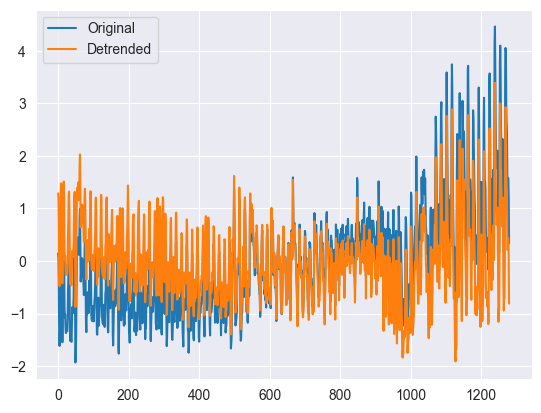

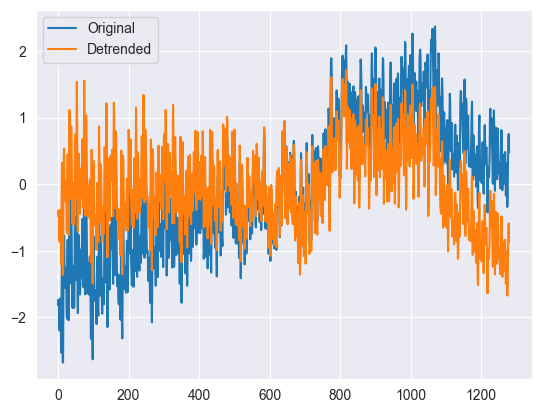

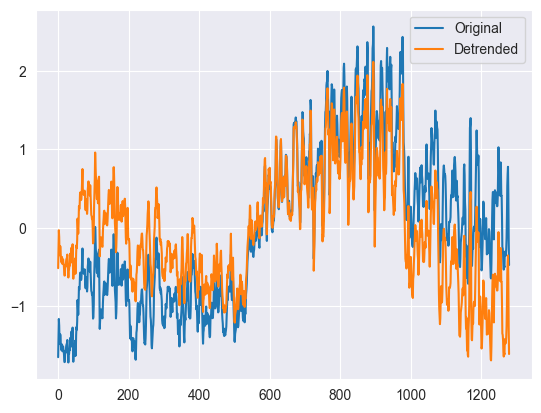

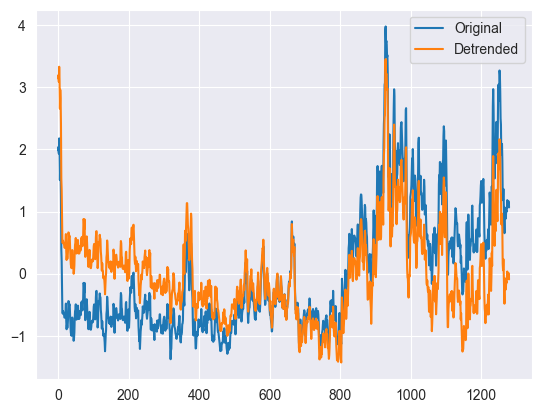

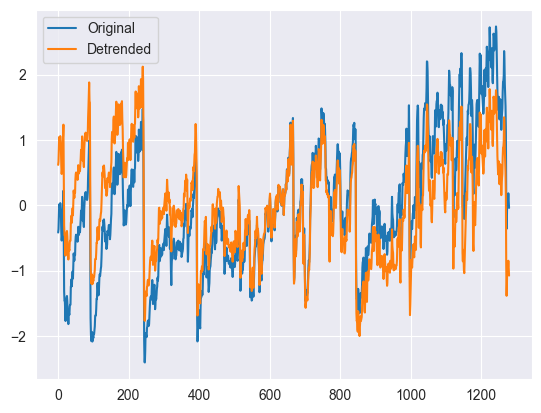

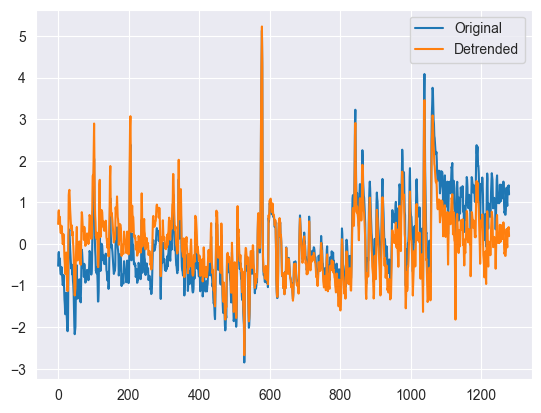

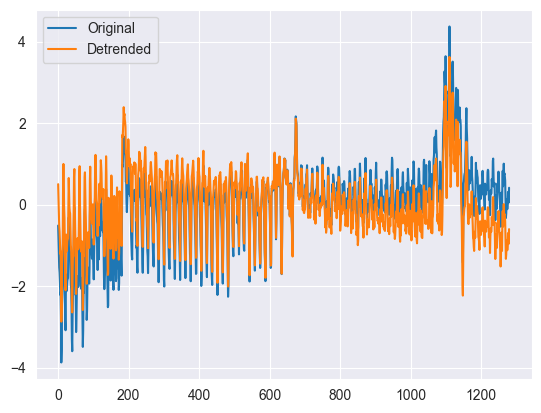

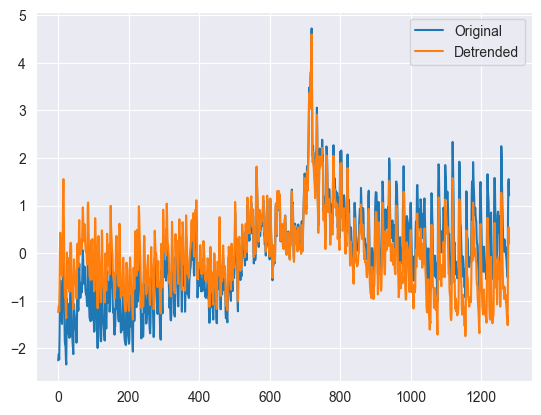

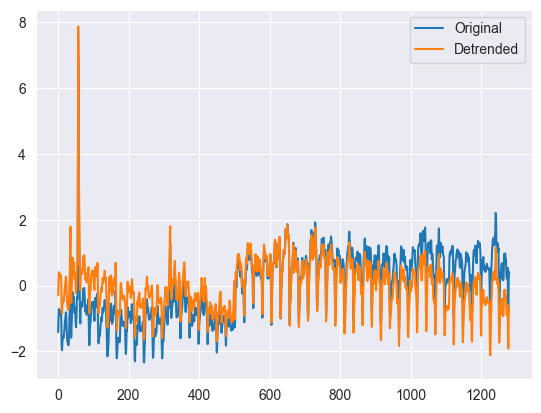

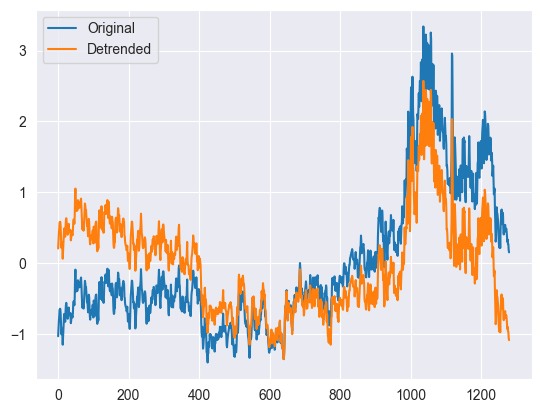

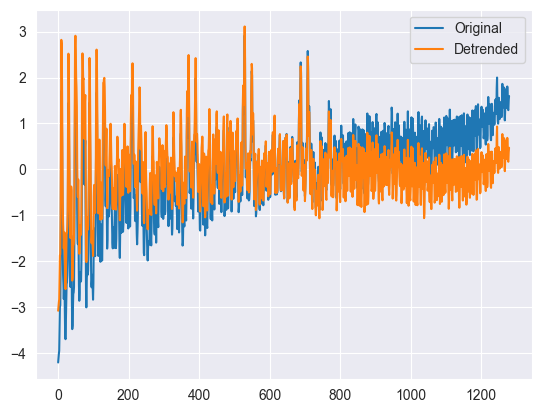

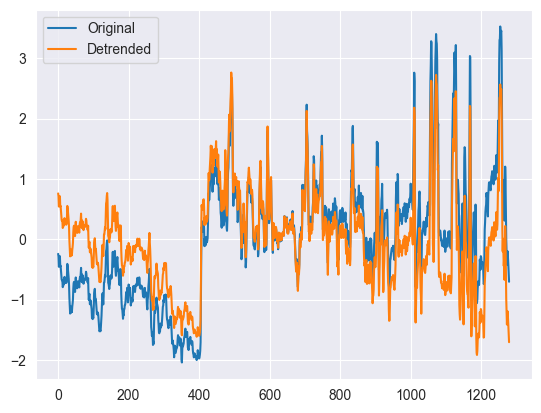

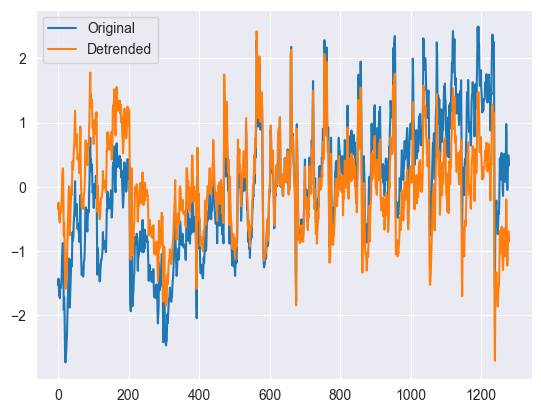

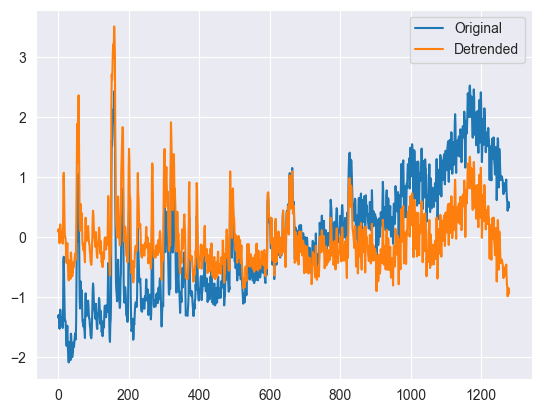

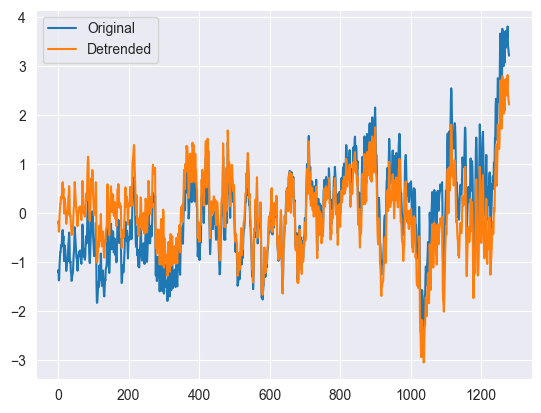

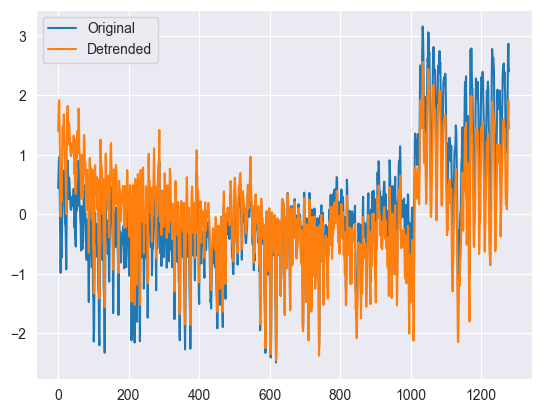

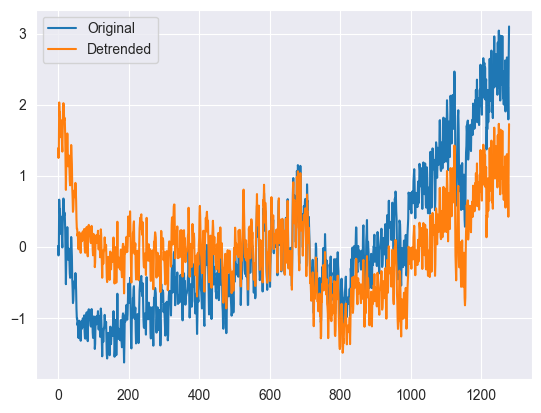

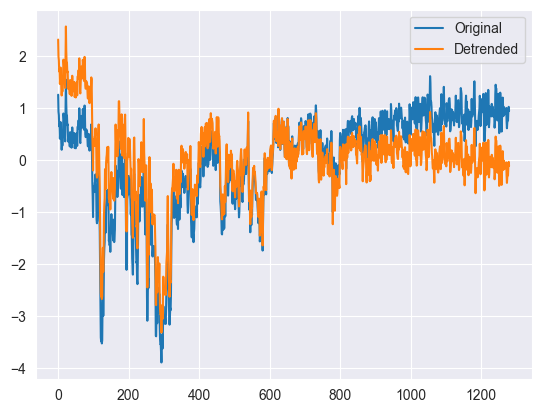

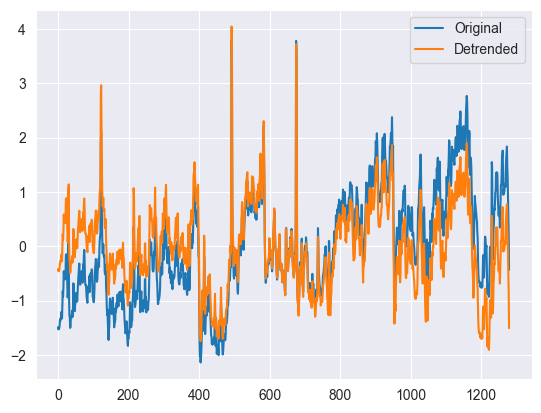

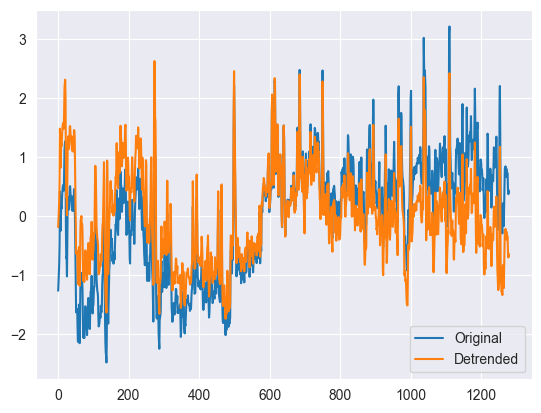

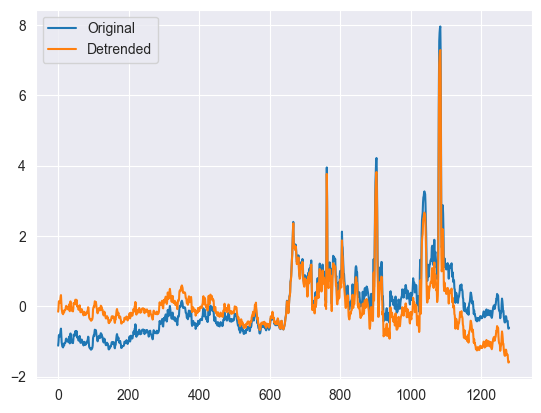

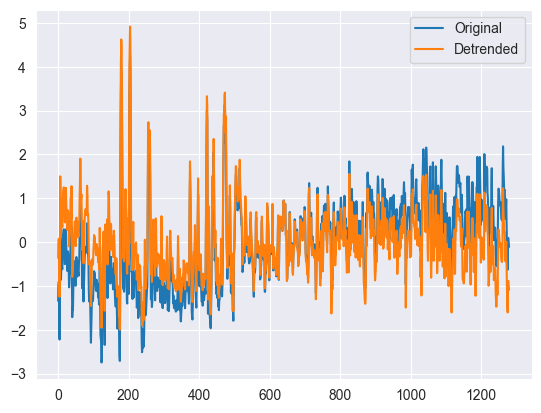

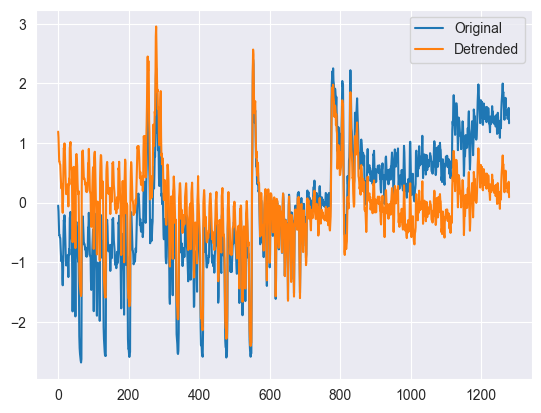

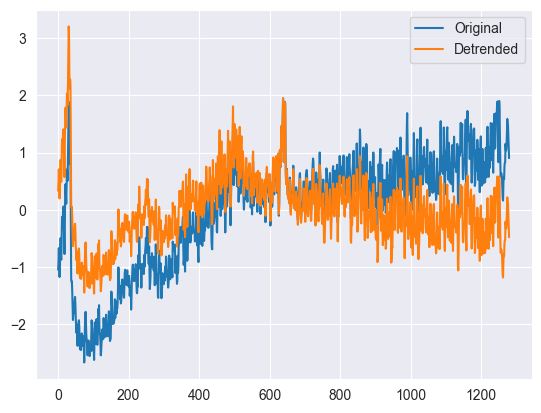

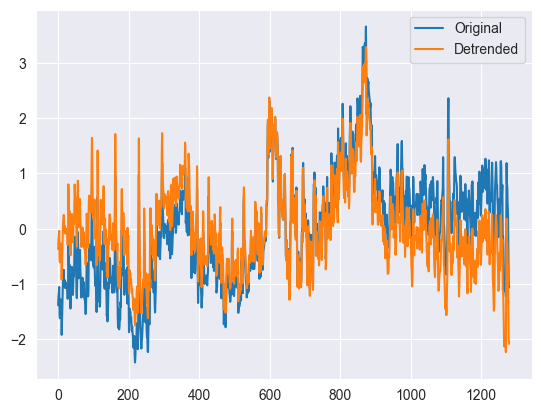

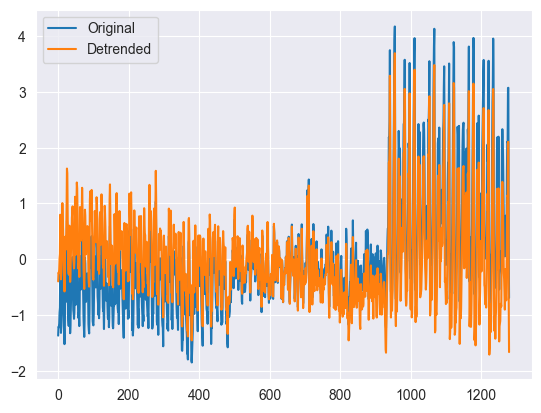

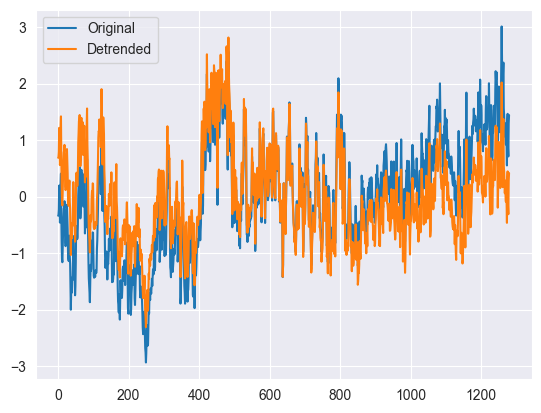

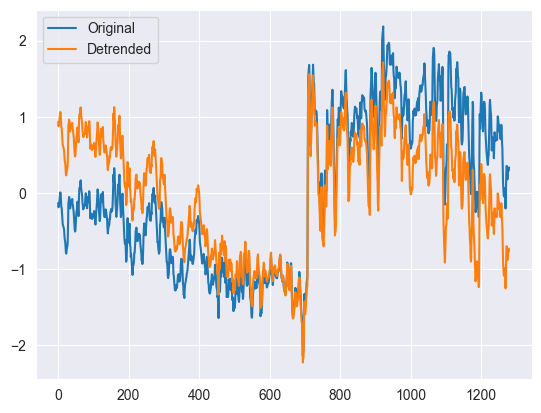

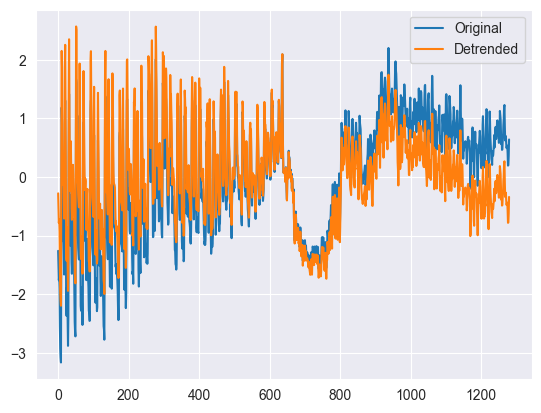

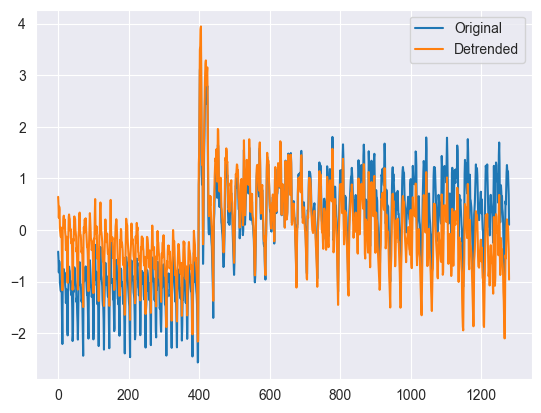

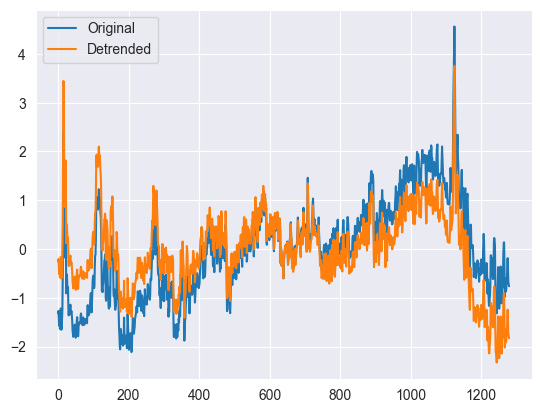

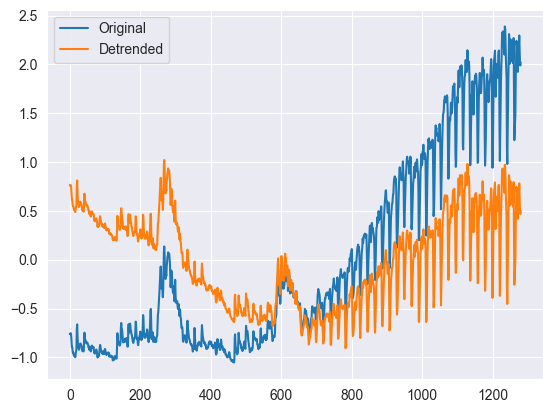

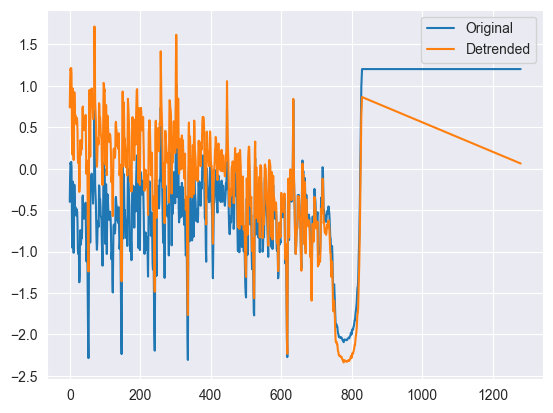

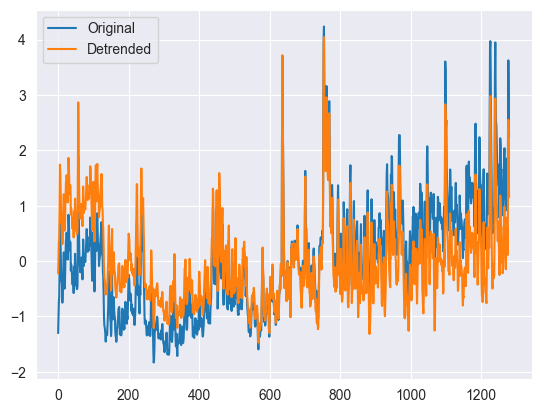

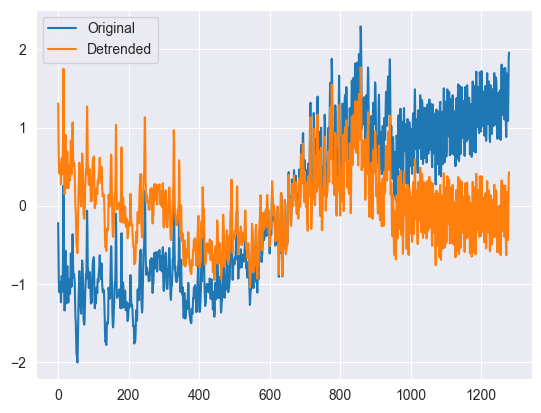

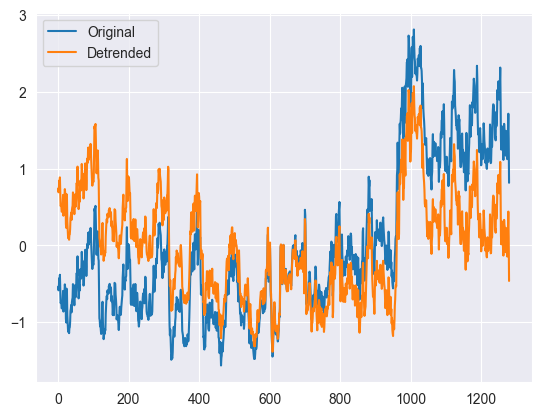

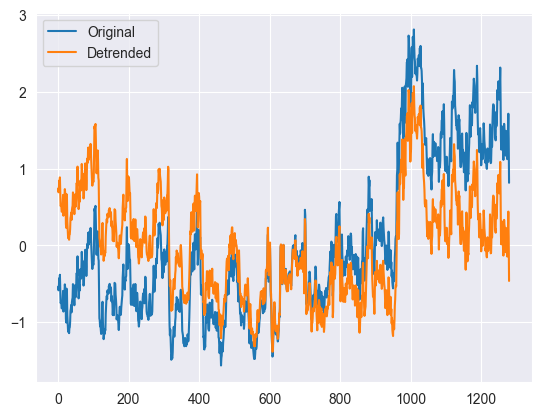

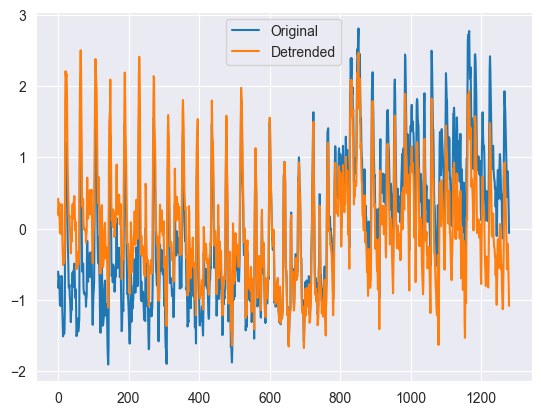

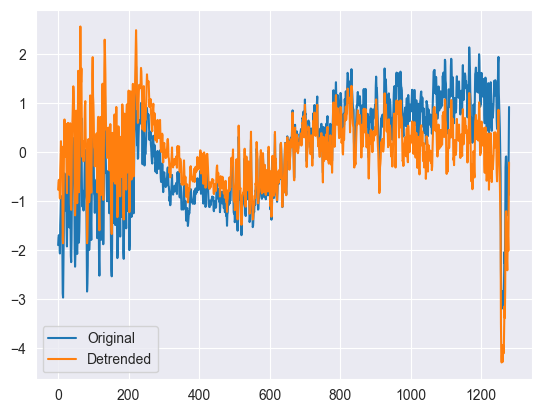

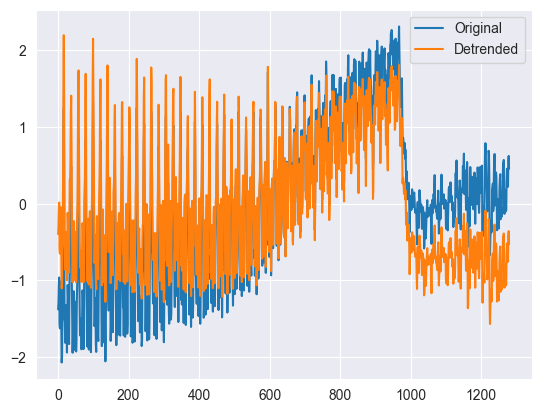

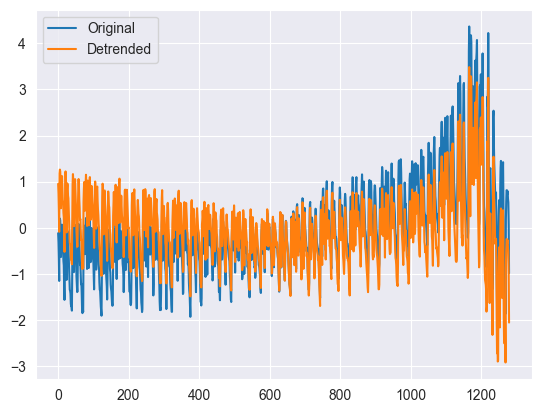

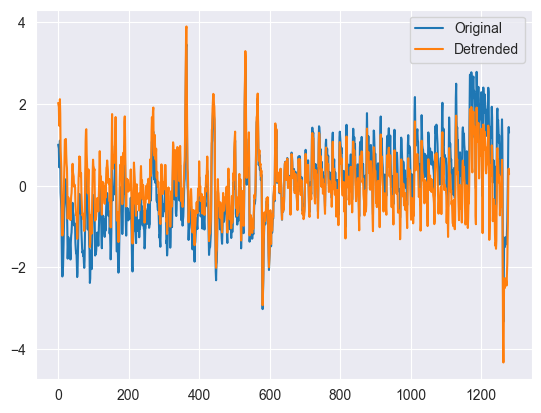

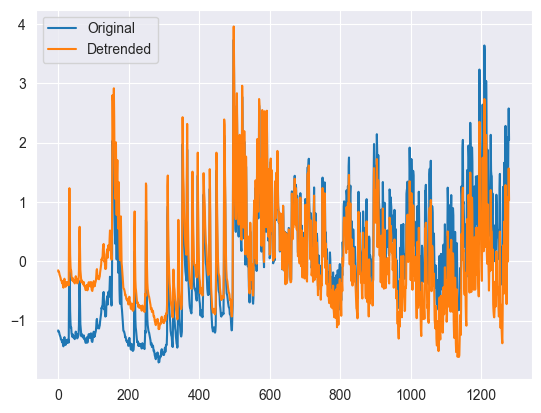

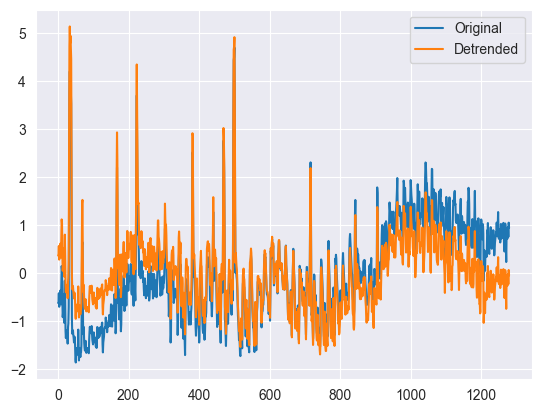

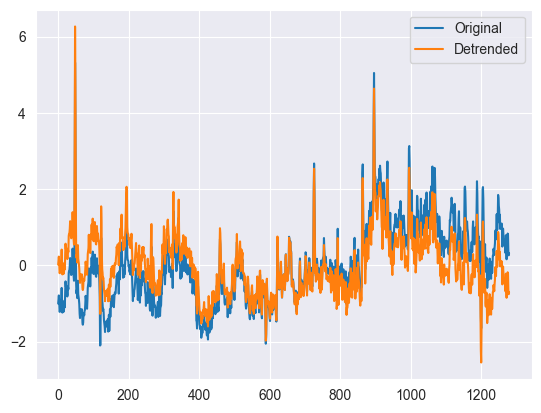

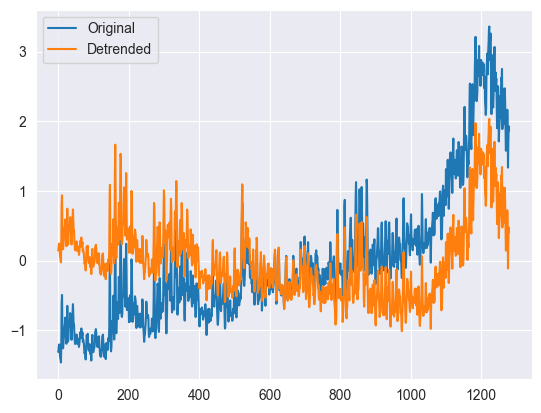

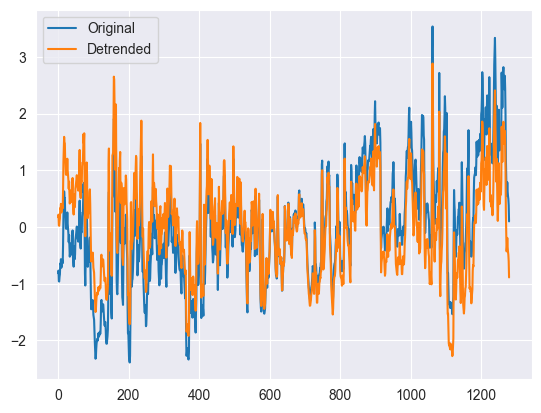

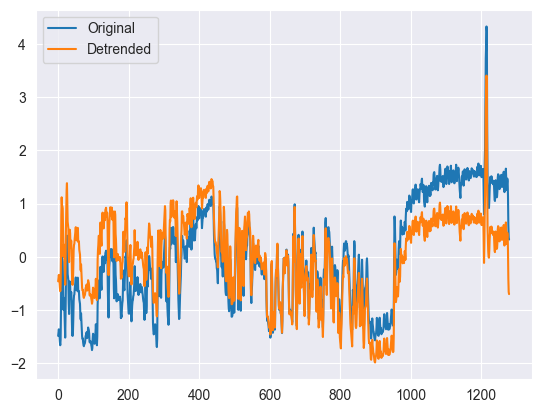

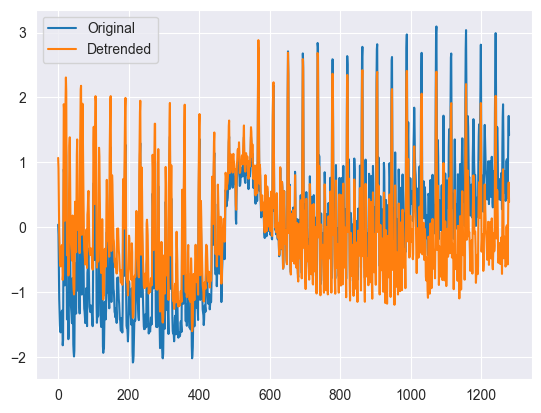

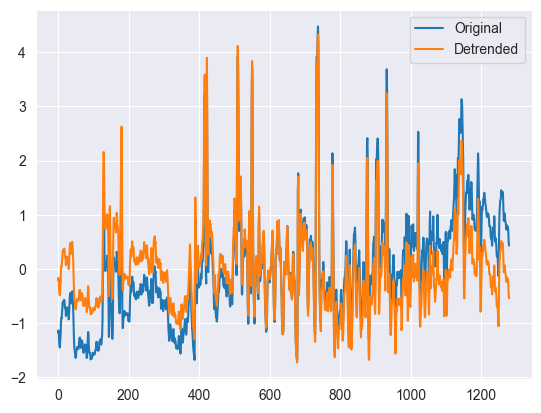

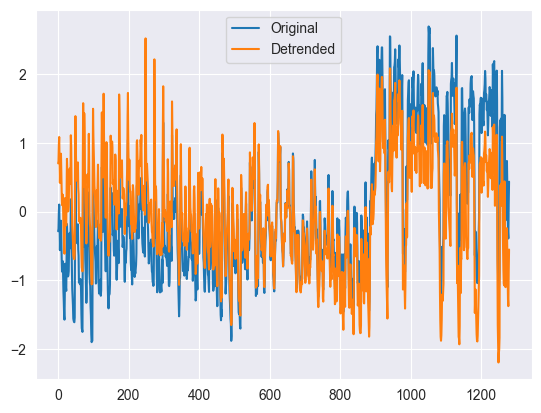

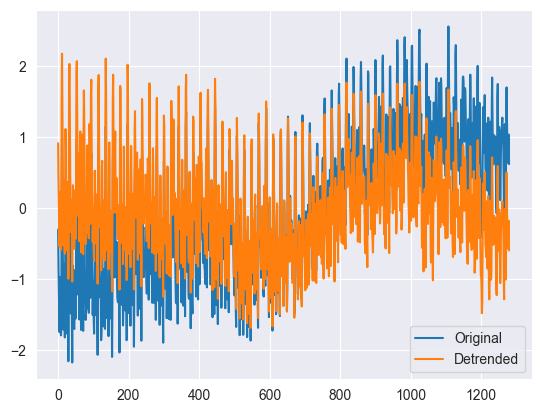

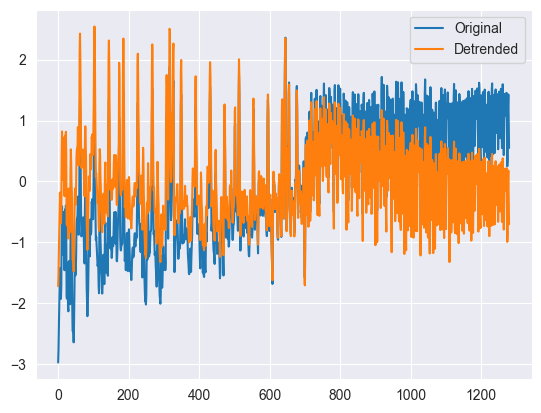

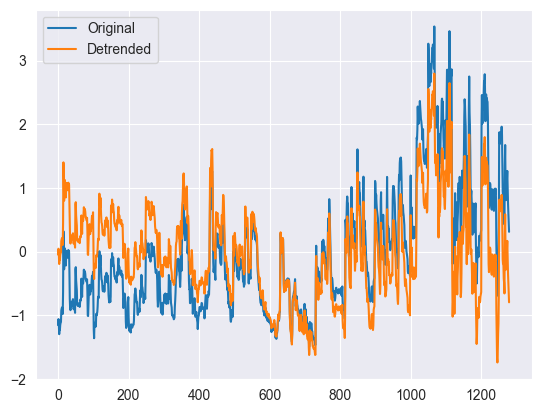

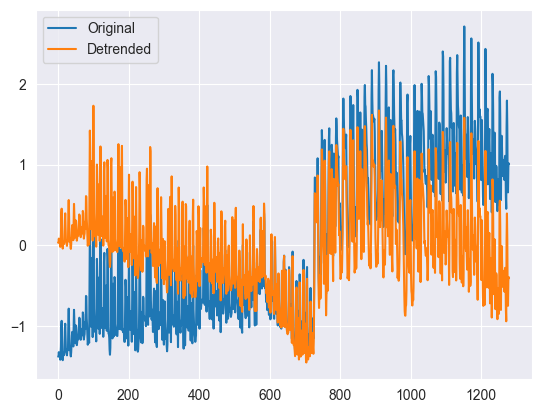

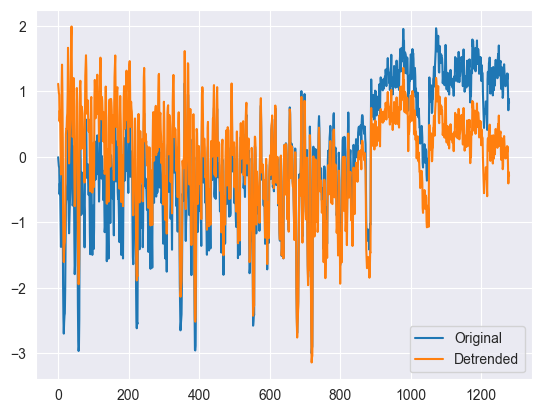

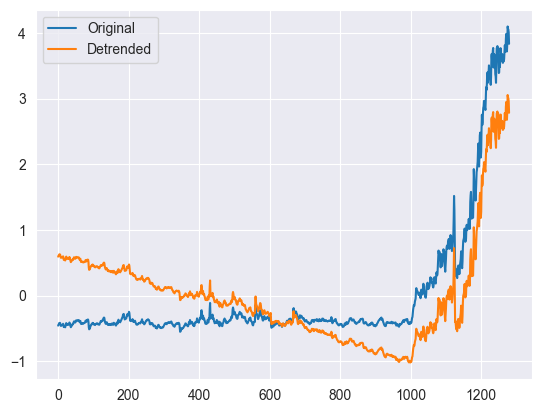

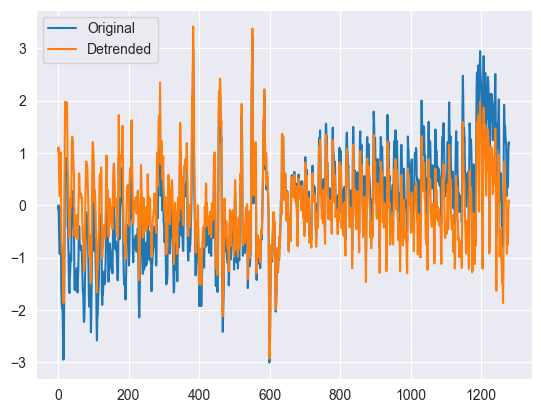

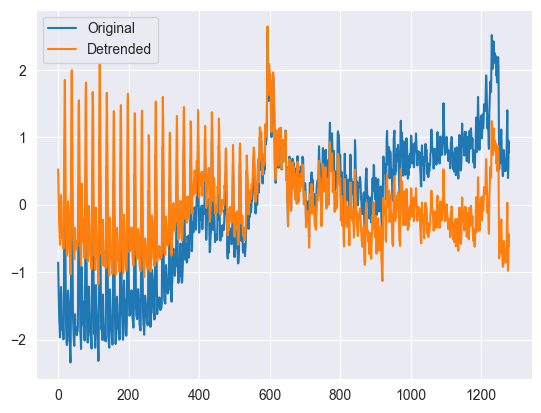

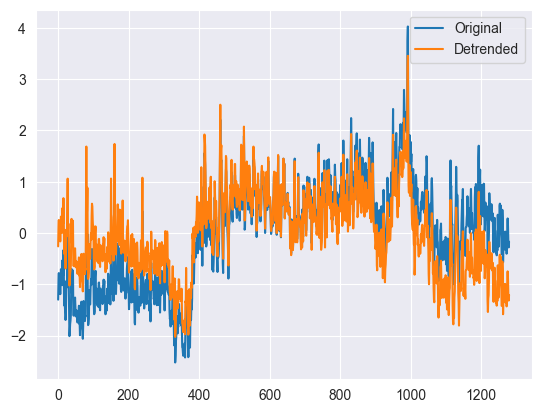

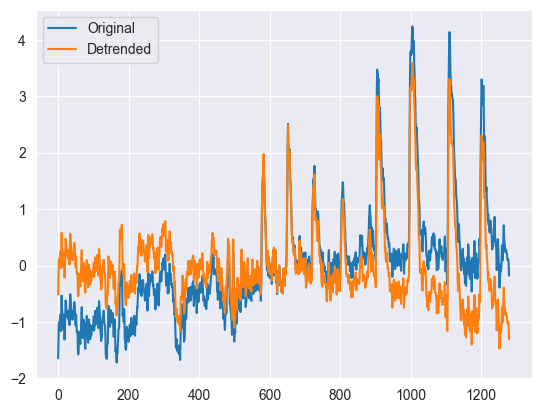

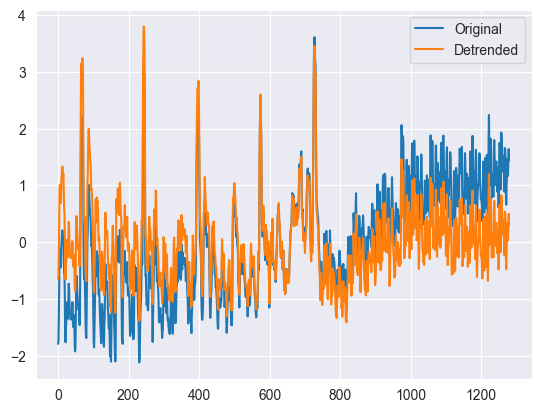

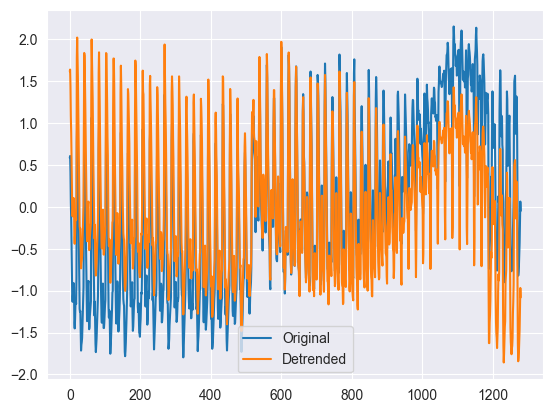

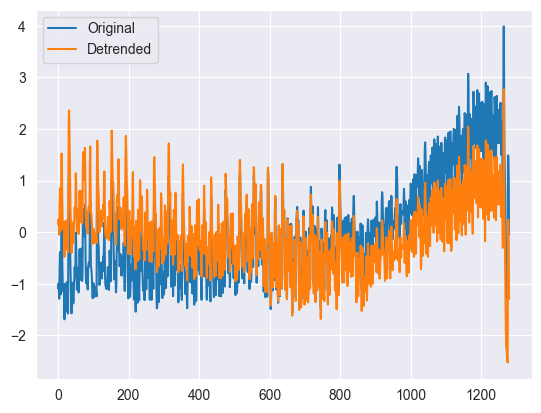

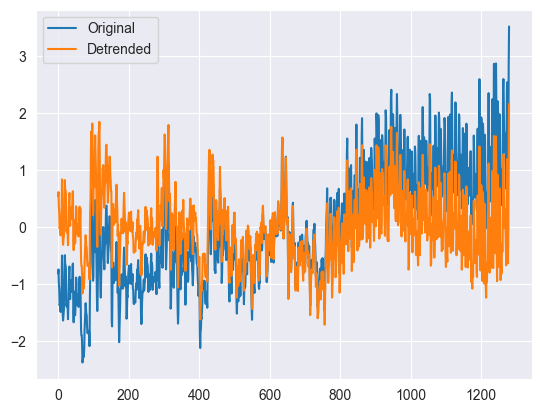

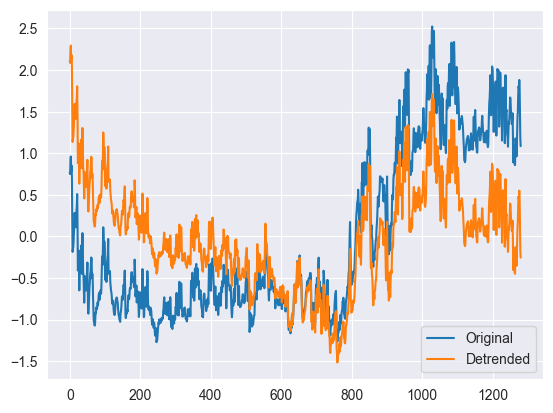

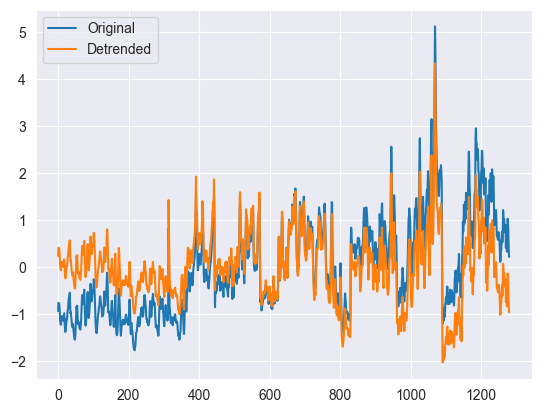

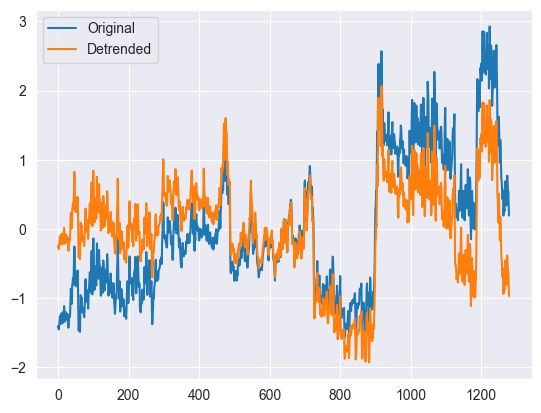

In [39]:
# Apply detrending to the trending time series

detrenders = Detrender()

for i in trending_series_indices:
    ts = pd.Series(X[i,-1].T)
    plt.plot(ts)
    ts_detrended = detrenders.fit_transform(ts)
    X[i,-1] = ts_detrended.values
    plt.plot(ts_detrended)
    plt.legend(['Original', 'Detrended'])
    plt.show()

## Exporting the cleaned time series data

In [40]:
# Directory di output per i file npy
output_directory = "cleaned_time_series/"

# Itera attraverso ciascuna serie temporale e salvala in un file npy
for i, serie in enumerate(X):
    # Trasponi la serie temporale prima di salvarla
    serie_trasposta = serie.reshape(-1, 1)  # Rappresenta la serie temporale come una singola colonna
    filename = f"{ids[i]}_{y[i]}.npy"
    np.save(os.path.join(output_directory, filename), serie_trasposta)

## Creating a dataset with features extracted from the time series data

In [ ]:
# Create a dataframe with features extracted from the time series data
features = pd.DataFrame()

# Add the mean value of each time series as a feature
for i in range(len(X)):
    features.loc[i, 'mean'] = np.mean(X[i,-1].T)
    features.loc[i, 'std'] = np.std(X[i,-1].T)
    features.loc[i, 'min'] = np.min(X[i,-1].T)
    features.loc[i, 'max'] = np.max(X[i,-1].T)
    features.loc[i, 'median'] = np.median(X[i,-1].T)
    features.loc[i, '25th_percentile'] = np.percentile(X[i,-1].T, 25)
    features.loc[i, '75th_percentile'] = np.percentile(X[i,-1].T, 75)
    features.loc[i, 'interquartile_range'] = np.percentile(X[i,-1].T, 75) - np.percentile(X[i,-1].T, 25)
    features.loc[i, 'skewness'] = pd.Series(X[i,-1].T).skew()
    features.loc[i, 'kurtosis'] = pd.Series(X[i,-1].T).kurtosis()
    features.loc[i, 'autocorrelation'] = pd.Series(X[i,-1].T).autocorr()
    features.loc[i, 'trend'] = estimate_slope(X[i,-1].T, np.arange(len(X[i,-1].T)))
    features.loc[i, 'ids'] = ids[i]